# Installing Dependencies  

In [1]:
!pip install matplotlib -q
!pip install scikit-learn -q
!pip install -U segmentation-models -q
!pip install patchify -q
!pip install Pillow -q

# Importing Libraries  

In [2]:
# Standard Library Imports
import os
import random

# Third-Party Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify

# Set environment variables
os.environ["SM_FRAMEWORK"] = "tf.keras"

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, 
    concatenate, Activation, Multiply, Add, BatchNormalization, 
    UpSampling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from keras.utils import to_categorical

# Segmentation Models
import segmentation_models as sm

# Scikit-Learn Utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Progress Bar
from tqdm import tqdm  


Segmentation Models: using `tf.keras` framework.


### Initialize Variables and Objects

Sets up the root directory for the dataset, initializes a scaler for normalization, and defines the patch size:
- **Root Directory:** Path to the dataset for semantic segmentation.
- **Scaler:** `MinMaxScaler()` from `sklearn.preprocessing` for normalizing data.
- **Patch Size:** Defines the size of image patches to be 256x256 pixels.

In [3]:
root_directory = "/kaggle/input/satelite-data/Semantic segmentation dataset"

scaler = MinMaxScaler()
patch_size = 256

### Patchifying Image Dataset

Processes images from the dataset, extracts patches, and normalizes them:
- **Image Dataset:** Initializes an empty list to store image patches.
- **Walk Through Directory:** Iterates over the directory to find 'images' folders.
- **Read and Process Images:**
  - Reads only JPG images.
  - Crops images to the nearest size divisible by `patch_size`.
  - Extracts patches of size `(patch_size, patch_size, 3)`.
  - Normalizes each patch using `MinMaxScaler` and appends to `image_dataset`.

In [4]:
image_dataset = []

for root, _, files in os.walk(root_directory):
    if root.endswith('images'):  # Find all 'images' directories
        print(f"Processing folder: {root}")
        for file in tqdm(sorted(files), desc=f"Patchifying images in {root}"):
            if file.endswith(".jpg"):  # Process only JPG images
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)  # Read image
                
                # Crop to nearest size divisible by patch_size
                height, width = image.shape[:2]
                SIZE_X = (width // patch_size) * patch_size
                SIZE_Y = (height // patch_size) * patch_size
                image = Image.fromarray(image).crop((0, 0, SIZE_X, SIZE_Y))
                image = np.array(image)

                # Extract patches of size (patch_size, patch_size, 3)
                patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                # Process each patch
                for row in patches:
                    for patch in row:
                        patch = patch[0]  # Remove extra dimension
                        patch = scaler.fit_transform(patch.reshape(-1, 3)).reshape(patch.shape)
                        image_dataset.append(patch)

Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 7/images


Patchifying images in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 7/images: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 8/images


Patchifying images in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 8/images: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 2/images


Patchifying images in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 2/images: 100%|██████████| 9/9 [00:00<00:00, 29.72it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 5/images


Patchifying images in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 5/images: 100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 1/images


Patchifying images in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 1/images: 100%|██████████| 9/9 [00:00<00:00, 10.60it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 3/images


Patchifying images in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 3/images: 100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 6/images


Patchifying images in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 6/images: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 4/images


Patchifying images in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 4/images: 100%|██████████| 9/9 [00:01<00:00,  5.35it/s]


### Patchifying Mask Dataset

Processes mask images from the dataset, extracts patches, and stores them:
- **Mask Dataset:** Initializes an empty list to store mask patches.
- **Walk Through Directory:** Iterates over the directory to find 'masks' folders.
- **Read and Process Masks:**
  - Reads only PNG mask images.
  - Converts BGR to RGB for consistency.
  - Crops masks to the nearest size divisible by `patch_size`.
  - Extracts patches of size `(patch_size, patch_size, 3)`.
  - Appends each patch to `mask_dataset`.

In [5]:
from tqdm import tqdm  # Import tqdm for progress tracking

mask_dataset = []

for root, _, files in os.walk(root_directory):
    if root.endswith('masks'):  # Find all 'masks' directories
        print(f"Processing folder: {root}")
        for file in tqdm(sorted(files), desc=f"Patchifying masks in {root}"):
            if file.endswith(".png"):  # Process only PNG images
                mask_path = os.path.join(root, file)
                mask = cv2.imread(mask_path, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

                # Crop to nearest size divisible by patch_size
                height, width = mask.shape[:2]
                SIZE_X = (width // patch_size) * patch_size
                SIZE_Y = (height // patch_size) * patch_size
                mask = Image.fromarray(mask).crop((0, 0, SIZE_X, SIZE_Y))
                mask = np.array(mask)

                # Extract patches of size (patch_size, patch_size, 3)
                patches = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

                # Process each patch
                for row in patches:
                    for patch in row:
                        mask_dataset.append(patch[0])  # Remove extra dimension


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 7/masks


Patchifying masks in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 7/masks: 100%|██████████| 9/9 [00:00<00:00, 13.63it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 8/masks


Patchifying masks in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 8/masks: 100%|██████████| 9/9 [00:00<00:00, 20.42it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 2/masks


Patchifying masks in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 2/masks: 100%|██████████| 9/9 [00:00<00:00, 237.33it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 5/masks


Patchifying masks in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 5/masks: 100%|██████████| 9/9 [00:00<00:00, 56.31it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 1/masks


Patchifying masks in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 1/masks: 100%|██████████| 9/9 [00:00<00:00, 113.65it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 3/masks


Patchifying masks in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 3/masks: 100%|██████████| 9/9 [00:00<00:00, 138.14it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 6/masks


Patchifying masks in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 6/masks: 100%|██████████| 9/9 [00:00<00:00, 87.99it/s]


Processing folder: /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 4/masks


Patchifying masks in /kaggle/input/satelite-data/Semantic segmentation dataset/Tile 4/masks: 100%|██████████| 9/9 [00:00<00:00, 90.24it/s]


### Convert Datasets to Numpy Arrays

In [6]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [7]:
image_dataset.shape

(1305, 256, 256, 3)

In [8]:
mask_dataset.shape

(1305, 256, 256, 3)

### Sanity Check - View Few Images

Randomly selects an image and its corresponding mask from the dataset, and displays them side by side for a visual sanity check:
- **Random Selection:** Selects a random index to pick an image and its mask.
- **Plot Configuration:**
  - Sets the figure size to `(12, 6)`.
  - Displays the selected image in the left subplot.
  - Displays the corresponding mask in the right subplot.

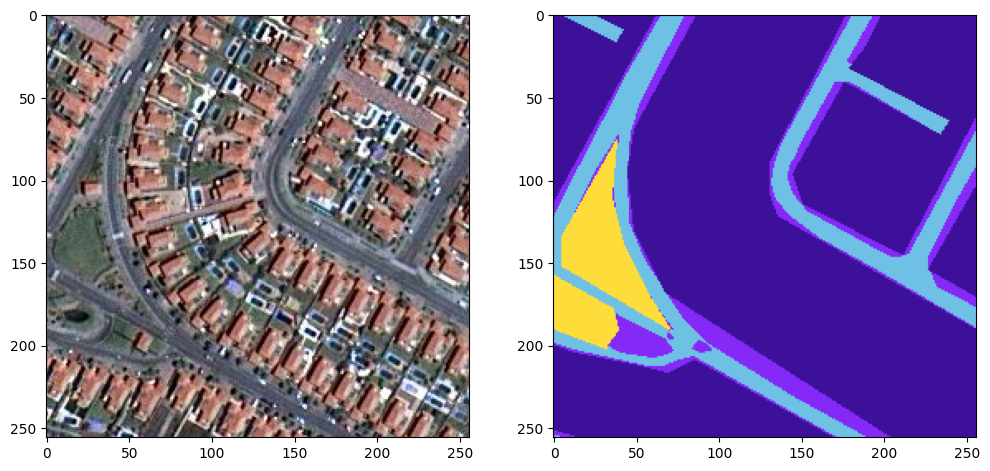

In [9]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

### Convert HEX to RGB Array

Creates a color map dictionary to convert specific RGB values to integer labels for different classes:
- **(60, 16, 152): 0** - Building
- **(132, 41, 246): 1** - Land
- **(110, 193, 228): 2** - Road
- **(254, 221, 58): 3** - Vegetation
- **(226, 169, 41): 4** - Water
- **(155, 155, 155): 5** - Unlabeled

In [10]:
#Convert HEX to RGB array
color_map = {
    (60, 16, 152): 0,    # Building
    (132, 41, 246): 1,   # Land
    (110, 193, 228): 2,  # Road
    (254, 221, 58): 3,   # Vegetation
    (226, 169, 41): 4,   # Water
    (155, 155, 155): 5   # Unlabeled
}

### RGB to 2D Label Conversion

Converts an RGB mask to a 2D label mask using the defined color map:
- **Initialize 2D Label Mask:** Creates an empty 2D label mask with the same height and width as the input mask.
- **Iterate and Assign Labels:** Iterates through the `color_map` dictionary and assigns corresponding labels to pixels matching specific RGB values.
- **Return Label Mask:** Returns the generated 2D label mask.

In [11]:
def rgb_to_2D_label(mask):
    #Convert an RGB mask to a 2D label mask.
    label_seg = np.zeros(mask.shape[:2], dtype=np.uint8)
    
    for rgb, label in color_map.items():
        label_seg[np.all(mask == rgb, axis=-1)] = label

    return label_seg

### Convert and Expand Mask Labels

Converts RGB mask images to 2D label masks and expands the dimension for compatibility:
- **Convert Masks:** Uses `rgb_to_2D_label` to convert each mask in `mask_dataset` to a 2D label mask.
- **Expand Dimension:** Adds an extra dimension to `labels` using `np.expand_dims` for compatibility with machine learning models.
- **Print Unique Labels:** Prints the unique labels in the `labels` dataset to verify the 

In [12]:
labels = np.array([rgb_to_2D_label(mask) for mask in mask_dataset])
labels = np.expand_dims(labels, axis=-1)

print("Unique labels in label dataset:", np.unique(labels))

Unique labels in label dataset: [0 1 2 3 4 5]


### Another Sanity check, view few mages

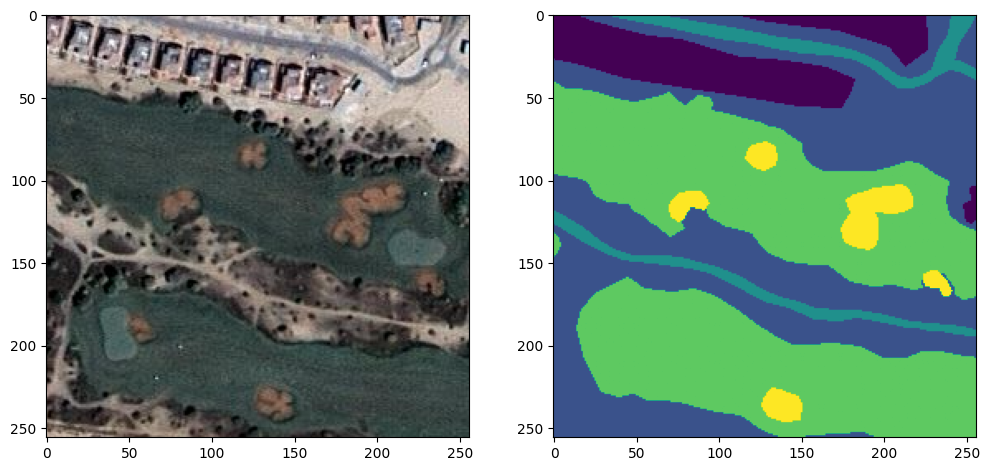

In [13]:

image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

### Prepare Dataset for Training

Prepares the dataset for training by converting labels to categorical format and splitting the data into training and test sets:
- **Number of Classes:** Computes the number of unique labels using `np.unique`.
- **Convert Labels to Categorical:** Converts the `labels` to one-hot encoded format using `to_categorical`.
- **Train-Test Split:**
  - Splits `image_dataset` and `labels_cat` into training and test sets.
  - **Test Size:** 10% of the data is used for testing.
  - **Random State:** 42, to ensure reproducibility.
  - **Shuffle:** Ensures the data is shuffled before splitting.

In [14]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, n_classes)


X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, labels_cat, test_size=0.1, random_state=42, shuffle=True
)



In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)  

### Print Dataset Sizes

Prints the total number of images in the training, validation, and test sets:
- **Total Training Images:** Prints the length of `X_train`.
- **Total Validation Set:** Prints the length of `X_val`.
- **Total Test Images:** Prints the length of `X_test`

In [16]:
print(f"Total training images: {len(X_train)}")
print(f"Total Validation set: {len(X_val)} ")
print(f"Total Test images: {len(X_test)}")

Total training images: 939
Total Validation set: 235 
Total Test images: 131


### Define Loss Functions and Total Loss

Configures the loss functions and combines them to create the total loss for model training:
- **Class Weights:** Sets the class weights for the Dice loss, with equal weights for all classes.
- **Dice Loss:** Initializes the Dice loss function with the specified class weights.
- **Focal Loss:** Initializes the Categorical Focal Loss function.
- **Total Loss:** Combines the Dice loss and Focal loss to form the total loss, with a weighting factor of 1 for the Focal loss.

In [17]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

### Define Image Dimensions

Sets the image dimensions based on the shape of the training data (`X_train`):
- **IMG_HEIGHT:** Height of the images, derived from the second dimension of `X_train`.
- **IMG_WIDTH:** Width of the images, derived from the third dimension of `X_train`.
- **IMG_CHANNELS:** Number of color channels in the images, derived from the fourth dimension of `X_train`.

In [18]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

### Jaccard Coefficient (Intersection over Union)

Calculates the Jaccard Coefficient, also known as Intersection over Union (IoU), for evaluating the similarity between predicted and true segmentation masks:


In [19]:
def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)


### Attention_Unet Model

In [20]:
def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)
    
    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(f)
    
    return Multiply()([x, psi_f])

def attention_unet(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Encoder Path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    bn = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    bn = Dropout(0.2)(bn)
    bn = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(bn)
    bn = BatchNormalization()(bn)
    
    # Decoder Path with Attention Gates
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn)
    a4 = attention_block(c4, u6, inter_channel=128//4)
    u6 = concatenate([u6, a4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    a3 = attention_block(c3, u7, inter_channel=64//4)
    u7 = concatenate([u7, a3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    a2 = attention_block(c2, u8, inter_channel=32//4)
    u8 = concatenate([u8, a2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    a1 = attention_block(c1, u9, inter_channel=16//4)
    u9 = concatenate([u9, a1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


### Model Definition and Compilation

Defines, compiles, and summarizes an Attention U-Net model:
- **Model Definition:**
  - `get_model()`: Returns an Attention U-Net model with 6 classes and input size 256x256 with 3 channels.
- **Model Compilation:**
  - **Optimizer:** Adam optimizer with a learning rate of 0.001.
  - **Loss Function:** `total_loss`.
  - **Metrics:** `accuracy` and `jacard_coef`.
- **Model Summary:** Displays the model architecture and 

In [21]:
def get_model():
    return attention_unet(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)


model = get_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=total_loss,
    metrics=['accuracy', jacard_coef]
)


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,953,278 (7.45 MB)

 Trainable params: 1,952,766 (7.45 MB)

 Non-trainable params: 512 (2.00 KB)

### Early Stopping and Model Training

Configures early stopping and trains the model with validation data:
- **Early Stopping:**
  - Monitors validation loss (`val_loss`).
  - Stops training if validation loss doesn't improve for 5 consecutive epochs (`patience=5`).
  - Restores the best weights observed during training (`restore_best_weights=True`).
- **Model Training:**
  - Uses `model.fit` to train the model on the training data (`X_train`, `y_train`).
  - **Batch Size:** 32
  - **Epochs:** 100
  - **Validation Data:** `(X_val, y_val)`
  - **Shuffle:** `False`
  - **Callbacks:** `early_stopping`
  - **Verbose:** 1 (prints training 

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train, y_train, 
    batch_size=32, 
    epochs=100, 
    validation_data=(X_val,  y_val), 
    shuffle=False, 
    callbacks=[early_stopping], 
    verbose=1
)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.3663 - jacard_coef: 0.1891 - loss: 1.0126 - val_accuracy: 0.5171 - val_jacard_coef: 0.3494 - val_loss: 1.0531
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - accuracy: 0.5428 - jacard_coef: 0.3252 - loss: 0.9894 - val_accuracy: 0.5751 - val_jacard_coef: 0.3535 - val_loss: 0.9886
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - accuracy: 0.5938 - jacard_coef: 0.3622 - loss: 0.9808 - val_accuracy: 0.6093 - val_jacard_coef: 0.3991 - val_loss: 1.0026
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - accuracy: 0.7070 - jacard_coef: 0.4376 - loss: 0.9602 - val_accuracy: 0.6787 - val_jacard_coef: 0.4326 - val_loss: 0.9616
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.7387 - jacard_coef: 0.4719 - loss: 0.9538 - val_accuracy: 0.7196 - val_jacard_coef: 0.4533 - val_loss: 0.9540
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.7546 - jacard_coef: 0.5019 - loss: 0.9468 - v

### Plotting Training and Validation Metrics

Visualizes the training and validation accuracy and loss over epochs:
- **Figure Configuration:** Sets the figure size to `(15, 5)`.
- **Accuracy Plot:** Plots training and validation accuracy over epochs in the left subplot.
  - Uses markers 'o-' and labels the plots.
  - Adds grid, labels, and legend.
- **Loss Plot:** Plots training and validation loss over epochs in the right subplot.
  - Uses markers 'o-' and labels the plots.
  - Adds grid, labels, and legend.
- **Display:** Uses `plt.show()` to display the plots.

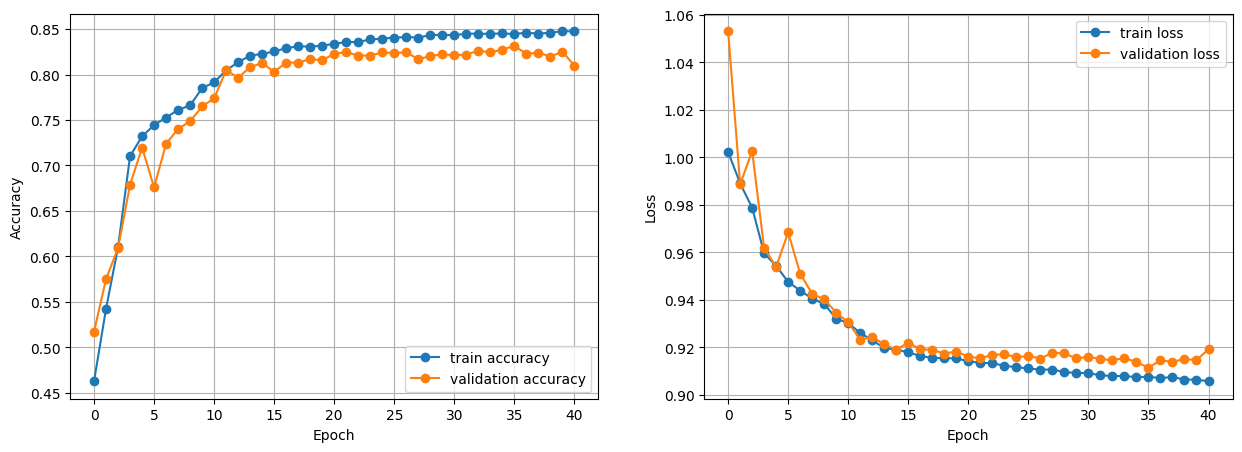

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

### Model Evaluation

Evaluates the trained model on the test data and prints the test accuracy, loss, and Jaccard coefficient:
- **Evaluate Model:** Uses `model.evaluate` to compute the loss, accuracy, and Jaccard coefficient on the test set.
- **Print Results:** Displays the test accuracy, test loss, and test Jaccard coefficient.

In [24]:
test_loss, test_acc, test_jaccard = model.evaluate(X_test, y_test)

print("\nTest Accuracy:", test_acc)
print("Test Loss:", test_loss)
print("Test Jaccard Coefficient:", test_jaccard)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 938ms/step - accuracy: 0.8509 - jacard_coef: 0.6984 - loss: 0.9089

Test Accuracy: 0.8557692766189575
Test Loss: 0.9092513918876648
Test Jaccard Coefficient: 0.7150426506996155


### Visualize Predictions vs Ground Truth


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


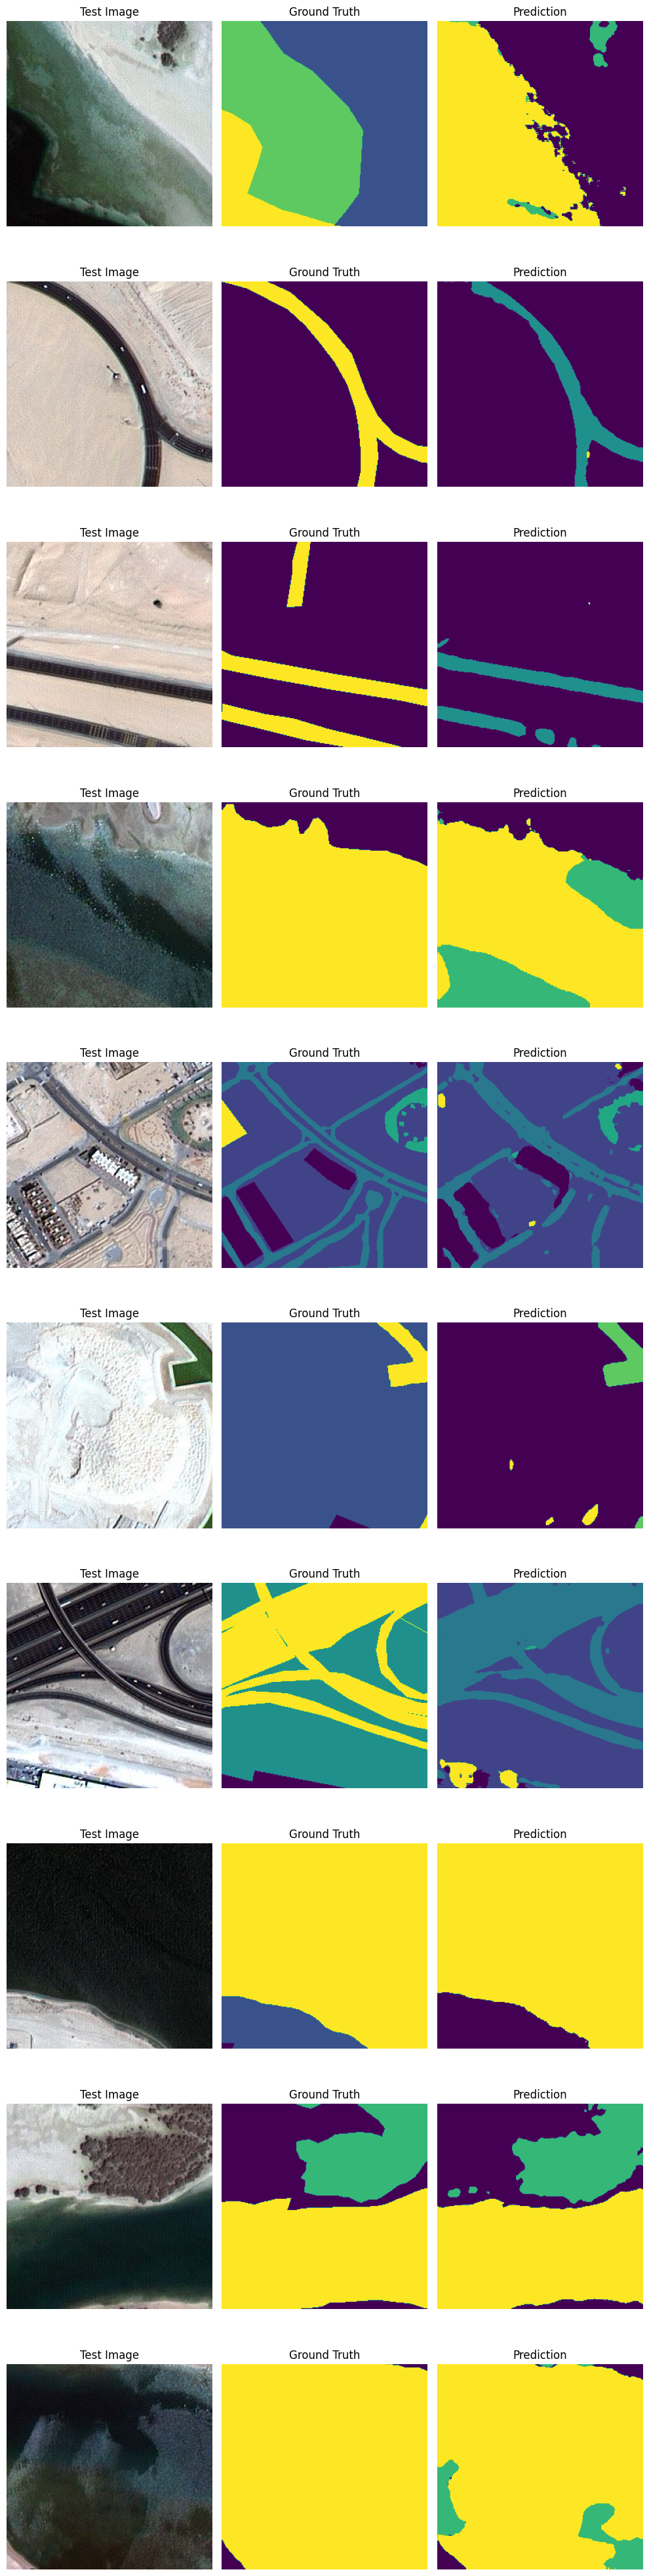

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random

num_images = 10  
plt.figure(figsize=(10, 40))

for i in range(num_images):
    idx = random.randint(0, len(X_test) - 1)  

    test_img = X_test[idx]
    ground_truth = np.argmax(y_test[idx], axis=2)
    predicted_img = np.argmax(model.predict(test_img[np.newaxis]), axis=3)[0]

    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(test_img)
    plt.title('Test Image', fontsize=12)
    plt.axis('off')

    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(ground_truth)
    plt.title('Ground Truth', fontsize=12)
    plt.axis('off')

    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(predicted_img)
    plt.title('Prediction', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()
